In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import pyodbc
import pandas as pd  # sure takes a long time
import dizzy_util as util
import eval_util
import numpy as np
import umap
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
import cluster_umap
from collections import defaultdict


In [3]:
dataset = util.extractDataset("B00_ML4TrgPos_", {"Notes", "AllMed", "Vital", "HF", "DispensedDrug"})

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_01_04_cohort,BASE TABLE
1,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_01_04_Demorgraphics,BASE TABLE
2,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_04_04_Lab,BASE TABLE
3,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_05_04_Rad,BASE TABLE
4,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_04_RxOutpat,BASE TABLE
5,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_05_BCMA_Dispense...,BASE TABLE
6,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_07_NonVAMed,BASE TABLE
7,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_08_AllMed,BASE TABLE
8,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_08_Consult,BASE TABLE
9,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_12_ICD,BASE TABLE


dict_keys(['cohort', 'Demorgraphics', 'Lab', 'Rad', 'RxOutpat', 'NonVAMed', 'Consult', 'ICD', 'Note', 'WithRole'])


In [4]:
dizziness_df, label_map = util.retrieveLabels()

In [5]:
dizziness_df["DxErrorERCoded"].value_counts()

NoMOD       44
MOD         38
PMOD        12
CodingEr     6
Name: DxErrorERCoded, dtype: Int64

In [6]:
label_df = util.convertLabelMap(label_map)

In [7]:
dizziness_df.DxErrorERCoded.astype("string").unique()

<StringArray>
['MOD', 'PMOD', 'NoMOD', 'CodingEr']
Length: 4, dtype: string

In [8]:
dizziness_df.columns

Index(['ID', 'StudyID', 'ReviewerID', 'NewStudyID',
       'Trigger positive/Negative', 'DxErrorER', 'DxErrorERCoded',
       'ReviewDate', 'PtSSN', 'Facility',
       ...
       'DimPatientOther', 'DimPtProvider', 'DimPtProviderOther',
       'DimDiagnosticTests', 'DimDiagnosticTestsOther', 'DimFollowTracking',
       'DimFollowTrackingOther', 'DimReferrals', 'DimReferralsOther',
       'CaseSummaryER'],
      dtype='object', length=105)

In [ ]:
dizziness_df.dropna(subset=["DxErrorER", "PtSSN"], inplace=True)
display(dizziness_df[["DxErrorER", "DxErrorERCoded"]])


In [10]:
datasubset = util.extractAndStandarizeCohort(dataset, "Dizziness")

In [ ]:
display(datasubset["cohort"])

In [23]:
icd_df = datasubset["ICD"]
cohort_df = datasubset["cohort"]

In [ ]:
display(icd_df)

In [14]:
edstart = util.extractFirstVisitIndexDatetime(datasubset["cohort"])

In [15]:
filtered_icd_df = util.filterDFByTimes(icd_df, util.ICD_PATIENT_ID, "DiagDateTime", edstart)

In [ ]:
display(filtered_icd_df)

In [ ]:
icd_features = util.makeICDFeatures(filtered_icd_df)
display(icd_features.norm_vec)

In [18]:
util.getICDCodes()["Smoking"]

['305.1',
 '305.1',
 '305.11',
 '305.12',
 '305.13',
 '649.0',
 '649.01',
 '649.02',
 '649.03',
 '649.04',
 'F17.200',
 'F17.203',
 'F17.208',
 'F17.209',
 'F17.210',
 'F17.213',
 'F17.218',
 'F17.219',
 'F17.220',
 'F17.223',
 'F17.228',
 'F17.229',
 'F17.290',
 'F17.293',
 'F17.298',
 'F17.299',
 'O99.330',
 'O99.331',
 'O99.332',
 'O99.333',
 'O99.334',
 'O99.335']

In [ ]:
# validate icd calculations
test_df = filtered_icd_df[filtered_icd_df.PatientSSN == 999]
util.displayAll(test_df[test_df.ICD.str.contains("F17", case=False)])
util.displayAll(test_df[test_df.ICD.str.contains("O99", case=False)])

In [ ]:
outpat_df = datasubset["RxOutpat"]
filtered_outpat_df = util.filterDFByTimes(outpat_df, util.DRUG_PATIENT_ID, "DispensedDate", edstart)
outpat_features = util.makeRxOutpatFeatureVector(filtered_outpat_df)
display(outpat_features)

In [ ]:
outpat_features = util.makeOutpatWindowFeatures(filtered_outpat_df, edstart)
display(outpat_features.norm_vec)

In [ ]:
util.makeRxOutpatTimeWindowVec(filtered_outpat_df, edstart)

In [23]:
util.getDrugCodesBySuperCategory()["cholesterol"]

['CV350']

In [ ]:
# validate results of window
test_df = filtered_outpat_df[filtered_outpat_df.PatientSSN == 999]
display(datasubset["cohort"][datasubset["cohort"].patientSSN == 999])
display(test_df)

In [55]:
display(outpat_features)

# Procedural

In [24]:
consult_feature = util.makeConsultFeature(datasubset["Consult"], cohort_df, edstart)
consult_vec = consult_feature.norm_vec

In [ ]:
display(consult_vec)

In [26]:
consult_vec[consult_vec.HasConsult > 1]

,HasConsult
PatientSSN,


In [27]:
rad_feature = util.makeRadFeature(datasubset["Rad"], cohort_df, edstart)
rad_vec = rad_feature.norm_vec

In [ ]:
util.displayAll(rad_vec)

In [ ]:
rad_df = datasubset["Rad"]
rad_df[rad_df.PatientSSN == 999].sort_values(by="ExamDateTime")

In [30]:
holidays = util.makeHolidayVec(edstart)
holidays[holidays["Holiday"] != 0]

,PatientSSN,IndexDate,Holiday


In [31]:
weekend_feature = util.makeWeekendFeature(edstart)

In [33]:
demo_df = datasubset["Demorgraphics"]
age_feature = util.makeAgeFeature(demo_df)
cohort_df = datasubset["cohort"]
index_feature = util.makeIndexFeature(cohort_df)

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


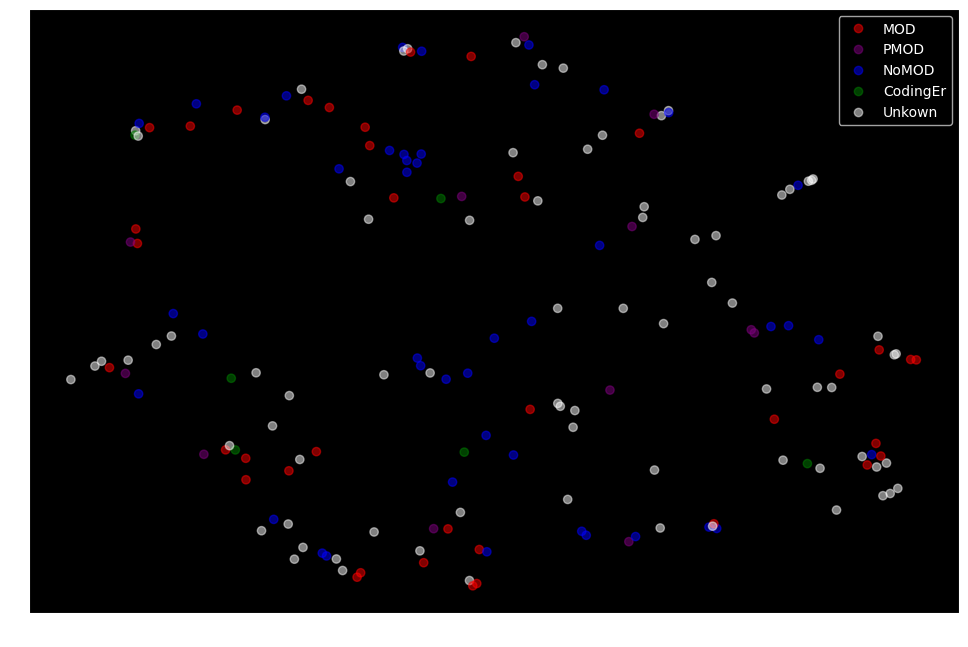

In [34]:
feature_vec10 = util.mergeFeatures([icd_features, consult_feature, rad_feature, weekend_feature, age_feature, index_feature])
reducer10 = umap.UMAP(metric="correlation", min_dist=0)
embedding10 = util.UMAPPlot(reducer10, feature_vec10, label_map)

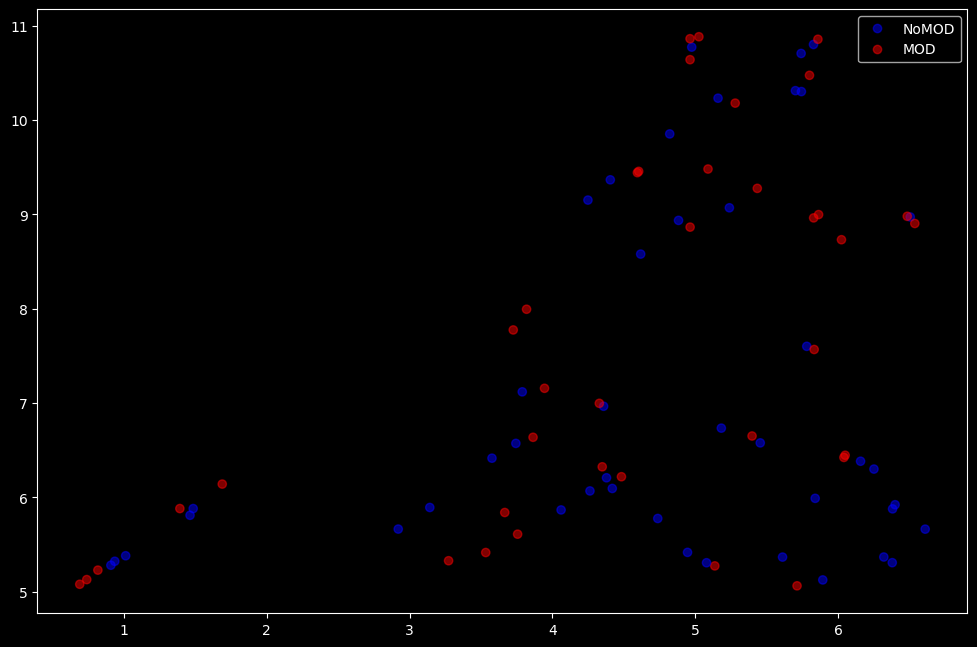

In [310]:


feature_vec11 = util.mergeFeatures([icd_features, outpat_features, consult_feature, rad_feature, weekend_feature, age_feature, index_feature])
reducer11 = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)

feature_vec11 = feature_vec11.merge(label_df[(label_df.Label == "NoMOD") | (label_df.Label == "MOD")])
embedding11 = reducer11.fit_transform(feature_vec11.iloc[:,1:-1])

# classes = ["MOD", "PMOD", "NoMOD", "CodingEr", "Unkown"]
# color_map = ["red", "red", "blue", "green", "white"]
# class_map = {"MOD": 0, "PMOD": 1, "NoMOD": 2, "CodingEr": 3, "Unkown": 4}
classes = ["NoMOD", "MOD"]
color_map = ["blue", "red"]
class_map = {"MOD": 1, "NoMOD": 0}
colors = [ class_map[label_map[id]] for id in feature_vec11.PatientSSN]
fig = plt.figure(figsize=(12,8), dpi=100)
plt.style.use("dark_background")
scatter = plt.scatter(embedding11[:, 0], embedding11[:, 1], c=colors, cmap=ListedColormap(color_map), alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

In [319]:
import heapq
import math

heap = []
for i in range(len(embedding11)):
    for j in range(i+1, len(embedding11)):
        if feature_vec11.iloc[i,-1] !=  feature_vec11.iloc[j,-1]:
            dist = math.dist(embedding11[i,:], embedding11[j,:])
            heapq.heappush(heap, (dist, (i, j)))

dizziness_df.PtSSN = dizziness_df.PtSSN.astype(int)

In [ ]:
l = heapq.nsmallest(5, heap)
print(l)
for d, (i,j) in l:
    print(feature_vec11.PatientSSN[i], feature_vec11.PatientSSN[j])
    
for d, (i,j) in l:
    display(feature_vec11.iloc[[i,j],:].T)
    util.displayAll(dizziness_df[(dizziness_df.PtSSN == feature_vec11.PatientSSN[i]) | (dizziness_df.PtSSN == feature_vec11.PatientSSN[j])].T)
    

In [ ]:
icd_diag_df = util.findERDiagnosis(icd_df, cohort_df)
display(icd_diag_df)
icd_codes = util.getICDCodes()
print(icd_codes.keys())
stroke_diags = util.filterDFByCodeSet(icd_diag_df, "ICD", icd_codes['Hx of stroke or TIA'])

In [ ]:
icd_diag_vec = pd.DataFrame({"PatientSSN":stroke_diags.PatientSSN.unique()})
icd_diag_vec["HasStrokeDiag"] = 1
display(icd_diag_vec)
icd_diag_feature = util.Feature(icd_diag_vec, "PatientSSN")

In [ ]:
icd_diag_vec.merge(label_df)

In [ ]:
dizziness_df[dizziness_df.PtSSN == 999]

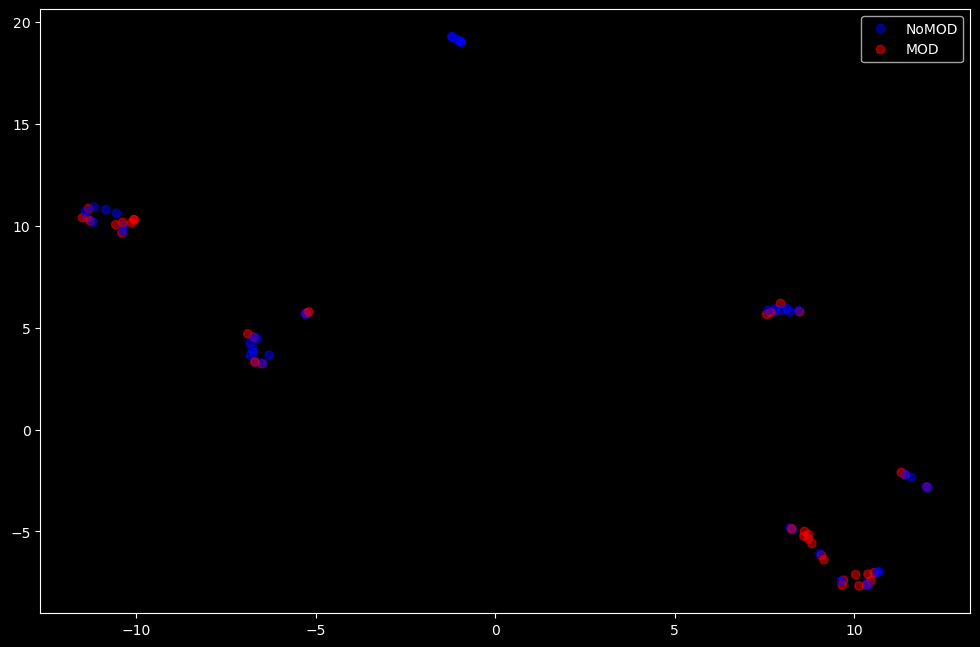

In [41]:
feature_vec12 = util.mergeFeatures([consult_feature, rad_feature, age_feature, index_feature, icd_diag_feature])
reducer12 = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)

feature_vec12 = feature_vec12.merge(label_df[(label_df.Label == "NoMOD") | (label_df.Label == "MOD")])
embedding12 = reducer12.fit_transform(feature_vec12.iloc[:,1:-1])

# classes = ["MOD", "PMOD", "NoMOD", "CodingEr", "Unkown"]
# color_map = ["red", "red", "blue", "green", "white"]
# class_map = {"MOD": 0, "PMOD": 1, "NoMOD": 2, "CodingEr": 3, "Unkown": 4}
classes = ["NoMOD", "MOD"]
color_map = ["blue", "red"]
class_map = {"MOD": 1, "NoMOD": 0}
colors = [ class_map[label_map[id]] for id in feature_vec12.PatientSSN]
fig = plt.figure(figsize=(12,8), dpi=100)
plt.style.use("dark_background")
scatter = plt.scatter(embedding12[:, 0], embedding12[:, 1], c=colors, cmap=ListedColormap(color_map), alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

In [ ]:
cluster_umap.run_clustering_on_umap(embedding12, 6, feature_vec12.iloc[:,0:-1], label_df[(label_df.Label == "NoMOD") | (label_df.Label == "MOD")])

In [43]:
label_df.Label.unique()

array(['MOD', 'PMOD', 'NoMOD', 'CodingEr'], dtype=object)

In [ ]:
feature_vec13 = util.mergeFeatures([new_consult_feature, new_rad_feature, age_feature, index_feature, icd_diag_feature])
reducer13 = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)

feature_vec13 = feature_vec13.merge(label_df, how="outer")
feature_vec13 = feature_vec13.fillna("Unknown")
feature_vec13 = feature_vec13[(feature_vec13.Label != "PMOD") & (feature_vec13.Label != "CodingEr")].copy()
feature_vec13.reset_index(inplace=True, drop=True)
display(feature_vec13)
embedding13 = util.UMAPPlot(reducer13, feature_vec13.iloc[:,0:-1], label_map)

In [ ]:
cluster_umap.run_clustering_on_umap(embedding13, 7, feature_vec13.iloc[:,0:-1], label_df[(label_df.Label == "NoMOD") | (label_df.Label == "MOD")].copy())

In [ ]:
util.UMAPClosestPairs(feature_vec13, embedding13)

In [ ]:
new_icd_vec = util.makeNewICDVec(filtered_icd_df)
display(new_icd_vec)
new_icd_feature = util.Feature(new_icd_vec, "PatientSSN")

In [ ]:
feature_vec14 = util.mergeFeatures([consult_feature, rad_feature, age_feature, index_feature, icd_diag_feature, new_icd_feature])
reducer14 = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)

feature_vec14 = feature_vec14.merge(label_df, how="outer")
feature_vec14 = feature_vec14.fillna("Unknown")
feature_vec14 = feature_vec14[(feature_vec14.Label != "PMOD") & (feature_vec14.Label != "CodingEr")].copy()
feature_vec14.reset_index(inplace=True, drop=True)
display(feature_vec14)
embedding14 = util.UMAPPlot(reducer14, feature_vec14.iloc[:,0:-1], label_map)

In [ ]:
cluster_umap.run_clustering_on_umap(embedding14, 7, feature_vec14.iloc[:,0:-1], label_df[(label_df.Label == "NoMOD") | (label_df.Label == "MOD")].copy())

In [ ]:
feature_vec15 = util.mergeFeatures([consult_feature, rad_feature, age_feature, index_feature, icd_diag_feature, new_icd_feature])
reducer15 = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)

feature_vec15 = feature_vec15.merge(label_df, how="outer")
feature_vec15 = feature_vec15.fillna("Unknown")
feature_vec15 = feature_vec15[(feature_vec15.Label != "PMOD") & (feature_vec15.Label != "CodingEr")].copy()
feature_vec15.reset_index(inplace=True, drop=True)
display(feature_vec15)
embedding15 = util.UMAPPlot(reducer15, feature_vec15.iloc[:,0:-1], label_map)

In [ ]:
cluster_umap.run_clustering_on_umap(embedding15, 7, feature_vec15.iloc[:,0:-1], label_df[(label_df.Label == "NoMOD") | (label_df.Label == "MOD")].copy())

In [54]:
feature_vec15.drop(["Label"], inplace=True, axis=1)

In [59]:
y_train.unique()

array([1., 0.])

In [58]:
X_train

,HasConsult,HasCT,HasMRI,Age,ed_duration,ed_inp_delta,HasStrokeDiag,Hx of stroke or TIA,Hx aneurysm,Atrial fibrillation,RiskFactorCount
71,0.0,0.0,0.0,0.926829,0.072531,0.113519,0.0,0.0,0.0,0.0,0.571429
136,0.0,0.0,0.0,0.536585,0.495238,0.436485,0.0,0.0,0.0,0.0,0.428571
95,1.0,1.0,0.0,0.512195,0.631240,0.229592,0.0,0.0,0.0,0.0,0.642857
151,0.0,1.0,0.0,0.560976,0.332886,0.477707,0.0,0.5,0.0,0.0,0.714286
123,0.0,1.0,0.0,0.975610,0.230683,0.036921,0.0,1.0,0.5,1.0,0.642857
...,...,...,...,...,...,...,...,...,...,...,...
46,0.0,1.0,0.0,0.804878,0.430253,0.077941,0.0,0.0,0.0,0.0,0.428571
121,0.0,1.0,0.0,0.682927,0.449692,0.195533,0.0,0.0,0.0,0.0,0.428571
138,1.0,1.0,0.0,0.609756,0.465639,0.210485,0.0,1.0,1.0,0.0,0.428571
35,0.0,1.0,0.0,0.853659,0.447739,0.367584,0.0,0.0,0.0,0.0,0.428571


In [64]:
unlabeled_df[X_cols]

,HasConsult,HasCT,HasMRI,Age,ed_duration,ed_inp_delta,HasStrokeDiag,Hx of stroke or TIA,Hx aneurysm,Atrial fibrillation,RiskFactorCount
0,0.0,1.0,0.0,0.731707,0.705700,0.024223,1.0,0.0,0.0,0.0,0.857143
3,1.0,0.0,1.0,0.390244,0.658152,0.407565,0.0,1.0,0.0,0.0,0.642857
6,0.0,1.0,0.0,0.317073,0.323239,0.292184,0.0,0.0,0.0,0.0,0.428571
7,0.0,1.0,0.0,0.439024,0.401167,0.064205,0.0,1.0,1.0,1.0,1.000000
8,1.0,1.0,0.0,0.560976,0.254835,0.041787,0.0,0.0,0.0,0.0,0.714286
...,...,...,...,...,...,...,...,...,...,...,...
147,0.0,1.0,0.0,0.926829,0.490720,0.028025,1.0,0.0,0.0,0.0,0.142857
148,0.0,1.0,1.0,0.902439,0.155441,0.046192,0.0,0.0,0.0,0.0,0.285714
149,0.0,1.0,0.0,0.634146,0.293494,0.170609,0.0,0.5,0.0,0.0,0.642857
152,0.0,1.0,0.0,0.878049,0.131337,0.039496,0.0,1.0,1.0,1.0,0.857143


In [70]:
util.displayAll(y_train)

71     1.0
136    0.0
95     0.0
151    0.0
123    0.0
115    0.0
79     0.0
20     1.0
155    1.0
13     1.0
100    1.0
70     0.0
129    0.0
85     1.0
113    1.0
41     0.0
78     1.0
122    0.0
157    0.0
17     1.0
159    0.0
112    0.0
44     0.0
133    1.0
55     1.0
93     1.0
34     0.0
118    1.0
5      0.0
42     1.0
75     0.0
19     0.0
127    0.0
15     1.0
73     0.0
144    1.0
128    1.0
107    0.0
99     1.0
158    1.0
38     1.0
58     1.0
83     0.0
56     1.0
102    0.0
53     1.0
92     1.0
140    0.0
117    0.0
23     0.0
66     1.0
154    0.0
120    1.0
124    0.0
137    1.0
74     0.0
61     0.0
2      0.0
110    0.0
47     0.0
4      1.0
52     0.0
153    0.0
150    0.0
46     1.0
121    1.0
138    0.0
35     1.0
109    1.0
Name: Label, dtype: float64

In [223]:
pseudo_labeler = cluster_umap.UMAPLabeler(reducer15, 7)
label_df3 = label_df[(label_df.Label == "NoMOD") | (label_df.Label == "MOD")]
labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(feature_vec15, label_df3)
X_train, X_test, y_train, y_test = train_test_split(labeled_df[X_cols], labeled_df[y_col], test_size=TEST_SIZE, random_state=RANDOM_STATE_SEED)
pX, plabels, label_cols = pseudo_labeler.label(X_train, y_train, unlabeled_df[X_cols])

,HasConsult,HasCT,HasMRI,Age,ed_duration,ed_inp_delta,HasStrokeDiag,Hx of stroke or TIA,Hx aneurysm,Atrial fibrillation,RiskFactorCount
0,0.0,0.0,0.0,0.926829,0.072531,0.113519,0.0,0.0,0.0,0.0,0.571429
1,0.0,0.0,0.0,0.536585,0.495238,0.436485,0.0,0.0,0.0,0.0,0.428571
2,1.0,1.0,0.0,0.512195,0.631240,0.229592,0.0,0.0,0.0,0.0,0.642857
3,0.0,1.0,0.0,0.560976,0.332886,0.477707,0.0,0.5,0.0,0.0,0.714286
4,0.0,1.0,0.0,0.975610,0.230683,0.036921,0.0,1.0,0.5,1.0,0.642857
...,...,...,...,...,...,...,...,...,...,...,...
142,0.0,1.0,0.0,0.926829,0.490720,0.028025,1.0,0.0,0.0,0.0,0.142857
143,0.0,1.0,1.0,0.902439,0.155441,0.046192,0.0,0.0,0.0,0.0,0.285714
144,0.0,1.0,0.0,0.634146,0.293494,0.170609,0.0,0.5,0.0,0.0,0.642857
145,0.0,1.0,0.0,0.878049,0.131337,0.039496,0.0,1.0,1.0,1.0,0.857143


(69,)
0 1.0
1 0.0


In [192]:
print(plabels.shape)

(97, 2)


In [194]:
display(pX)

,HasConsult,HasCT,HasMRI,Age,ed_duration,ed_inp_delta,HasStrokeDiag,Hx of stroke or TIA,Hx aneurysm,Atrial fibrillation,RiskFactorCount
0,0.0,0.0,0.0,0.926829,0.072531,0.113519,0.0,0.0,0.0,0.0,0.571429
1,0.0,0.0,0.0,0.536585,0.495238,0.436485,0.0,0.0,0.0,0.0,0.428571
2,1.0,1.0,0.0,0.512195,0.631240,0.229592,0.0,0.0,0.0,0.0,0.642857
3,0.0,1.0,0.0,0.560976,0.332886,0.477707,0.0,0.5,0.0,0.0,0.714286
4,0.0,1.0,0.0,0.975610,0.230683,0.036921,0.0,1.0,0.5,1.0,0.642857
...,...,...,...,...,...,...,...,...,...,...,...
136,0.0,1.0,0.0,0.414634,0.302848,0.006634,1.0,0.0,0.0,0.0,0.428571
141,1.0,1.0,0.0,0.073171,0.336207,0.004551,0.0,0.0,0.0,0.0,0.285714
142,0.0,1.0,0.0,0.926829,0.490720,0.028025,1.0,0.0,0.0,0.0,0.142857
143,0.0,1.0,1.0,0.902439,0.155441,0.046192,0.0,0.0,0.0,0.0,0.285714


In [149]:
y_train

71     1.0
136    0.0
95     0.0
151    0.0
123    0.0
      ... 
46     1.0
121    1.0
138    0.0
35     1.0
109    1.0
Name: Label, Length: 69, dtype: float64

In [196]:
import pseudo_label
pX, py, pw = pseudo_label.pseudo_label_dataset(pseudo_labeler, X_train, y_train, unlabeled_df[X_cols])

,HasConsult,HasCT,HasMRI,Age,ed_duration,ed_inp_delta,HasStrokeDiag,Hx of stroke or TIA,Hx aneurysm,Atrial fibrillation,RiskFactorCount
0,0.0,0.0,0.0,0.926829,0.072531,0.113519,0.0,0.0,0.0,0.0,0.571429
1,0.0,0.0,0.0,0.536585,0.495238,0.436485,0.0,0.0,0.0,0.0,0.428571
2,1.0,1.0,0.0,0.512195,0.631240,0.229592,0.0,0.0,0.0,0.0,0.642857
3,0.0,1.0,0.0,0.560976,0.332886,0.477707,0.0,0.5,0.0,0.0,0.714286
4,0.0,1.0,0.0,0.975610,0.230683,0.036921,0.0,1.0,0.5,1.0,0.642857
...,...,...,...,...,...,...,...,...,...,...,...
142,0.0,1.0,0.0,0.926829,0.490720,0.028025,1.0,0.0,0.0,0.0,0.142857
143,0.0,1.0,1.0,0.902439,0.155441,0.046192,0.0,0.0,0.0,0.0,0.285714
144,0.0,1.0,0.0,0.634146,0.293494,0.170609,0.0,0.5,0.0,0.0,0.642857
145,0.0,1.0,0.0,0.878049,0.131337,0.039496,0.0,1.0,1.0,1.0,0.857143


(69,)
0 1.0
1 0.0


In [197]:
print(pX.shape, py.shape, pw.shape)

(194, 11) (194,) (194,)


In [174]:
pw

array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 1.        , 1.        ,
       1.        , 0.        , 0.        , 1.        , 1.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 1.        ,
       1.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       1.        , 1.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       1.        , 0.        , 1.        , 1.        , 0.28571429,
       0.5       , 0.76923077, 0.44444444, 0.28571429, 0.38461

In [176]:
from sklearn import linear_model

regr = linear_model.Ridge(alpha=0.1)
regr.fit(pX.iloc[:147,:], pw[:147])

Ridge(alpha=0.1)

In [177]:
predictions = regr.predict(X_test)
predictions2 = regr.predict(pX.iloc[:147,:])

In [178]:
(predictions>0.49).astype(float)

array([0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.])

In [179]:
from sklearn import metrics

In [ ]:
np.mean(predictions2)

In [183]:
sum((pw[:147] > 0.9).astype(float))

32.0

In [181]:
print(metrics.confusion_matrix(y_test, (predictions>0.5).astype(float)))
print(metrics.classification_report(y_test, (predictions>0.5).astype(float)))
print(metrics.confusion_matrix((pw[:147] > 0.5).astype(float), (predictions2>0.5).astype(float)))
print(metrics.classification_report((pw[:147] > 0.5).astype(float), (predictions2>0.5).astype(float)))

[[5 2]
 [2 4]]
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71         7
         1.0       0.67      0.67      0.67         6

    accuracy                           0.69        13
   macro avg       0.69      0.69      0.69        13
weighted avg       0.69      0.69      0.69        13

[[88 19]
 [22 18]]
              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81       107
         1.0       0.49      0.45      0.47        40

    accuracy                           0.72       147
   macro avg       0.64      0.64      0.64       147
weighted avg       0.71      0.72      0.72       147



Best penalty: l1
Best C: 1.6681005372000592
Best solver: liblinear
[[7 0]
 [3 3]]
              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82         7
         1.0       1.00      0.50      0.67         6

    accuracy                           0.77        13
   macro avg       0.85      0.75      0.75        13
weighted avg       0.84      0.77      0.75        13

[[77 20]
 [77 20]]
              precision    recall  f1-score   support

         0.0       0.50      0.79      0.61        97
         1.0       0.50      0.21      0.29        97

    accuracy                           0.50       194
   macro avg       0.50      0.50      0.45       194
weighted avg       0.50      0.50      0.45       194

Best n_estimators: 2
Best max_depth: 2
[[4 3]
 [2 4]]
              precision    recall  f1-score   support

         0.0       0.67      0.57      0.62         7
         1.0       0.57      0.67      0.62         6

    accuracy               

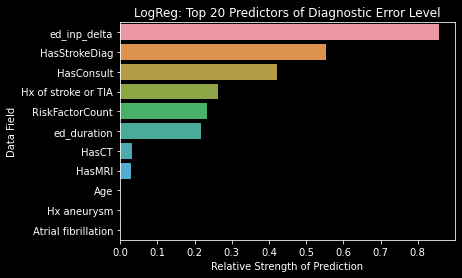

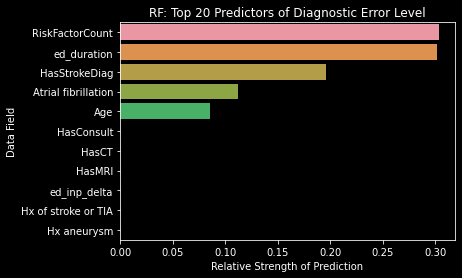

In [198]:
# define space of model's parameter values
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-1, 10, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

best_model_log = eval_util.runLogRegWithDataset(hyperparameter_grid_log, X_cols, pX, X_test, py, y_test, pw)

# define space of model's parameter values
hyperparameter_grid_rf = {
    'n_estimators': [1, 2, 3, 5, 7]
    ,'max_depth': [2, 3, 4, 5]
}

best_model_rf = eval_util.runRandForestWithDataset(hyperparameter_grid_rf, X_cols, pX, X_test, py, y_test, pw)

,HasConsult,HasCT,HasMRI,Age,ed_duration,ed_inp_delta,HasStrokeDiag,Hx of stroke or TIA,Hx aneurysm,Atrial fibrillation,RiskFactorCount
0,0.0,0.0,0.0,0.926829,0.072531,0.113519,0.0,0.0,0.0,0.0,0.571429
1,0.0,0.0,0.0,0.536585,0.495238,0.436485,0.0,0.0,0.0,0.0,0.428571
2,1.0,1.0,0.0,0.512195,0.631240,0.229592,0.0,0.0,0.0,0.0,0.642857
3,0.0,1.0,0.0,0.560976,0.332886,0.477707,0.0,0.5,0.0,0.0,0.714286
4,0.0,1.0,0.0,0.975610,0.230683,0.036921,0.0,1.0,0.5,1.0,0.642857
...,...,...,...,...,...,...,...,...,...,...,...
142,0.0,1.0,0.0,0.926829,0.490720,0.028025,1.0,0.0,0.0,0.0,0.142857
143,0.0,1.0,1.0,0.902439,0.155441,0.046192,0.0,0.0,0.0,0.0,0.285714
144,0.0,1.0,0.0,0.634146,0.293494,0.170609,0.0,0.5,0.0,0.0,0.642857
145,0.0,1.0,0.0,0.878049,0.131337,0.039496,0.0,1.0,1.0,1.0,0.857143


array([[0.5       , 0.5       ],
       [0.76923077, 0.23076923],
       [0.35714286, 0.64285714],
       [0.44444444, 0.55555556],
       [0.28571429, 0.71428571],
       [0.38461538, 0.61538462],
       [0.        , 1.        ]])

(69,)
0 1.0
1 0.0
Best penalty: l1
Best C: 0.1
Best solver: liblinear
[[7 0]
 [6 0]]
              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70         7
         1.0       0.00      0.00      0.00         6

    accuracy                           0.54        13
   macro avg       0.27      0.50      0.35        13
weighted avg       0.29      0.54      0.38        13

[[120   0]
 [120   0]]
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       120
         1.0       0.00      0.00      0.00       120

    accuracy                           0.50       240
   macro avg       0.25      0.50      0.33       240
weighted avg       0.25      0.50      0.33       240



C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


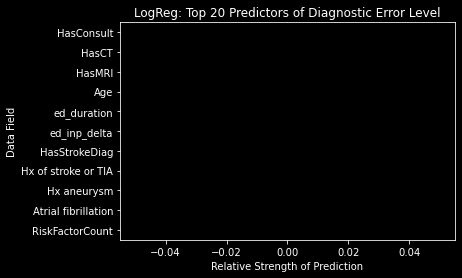

In [232]:
# try cutoff
pX, py, pw = pseudo_label.pseudo_label_dataset(pseudo_labeler, X_train, y_train, unlabeled_df[X_cols], 0.6)
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-1, 10, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

best_model_log = eval_util.runLogRegWithDataset(hyperparameter_grid_log, X_cols, pX, X_test, py, y_test, pw)

In [214]:
label_df3 = label_df[(label_df.Label == "NoMOD") | (label_df.Label == "MOD")]
labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(feature_vec15, label_df3)
X_train, X_test, y_train, y_test = train_test_split(labeled_df[X_cols + ["PatientSSN"]], labeled_df[[y_col, "PatientSSN"]], test_size=TEST_SIZE, random_state=RANDOM_STATE_SEED)

In [ ]:
display(X_train)

In [ ]:
display(y_train)

In [ ]:
# train embedding only using train set + unlabeled
reducer16 = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)
feature_vec16 = pd.concat([X_train, unlabeled_df], axis=0)
feature_vec16.reset_index(inplace=True, drop=True)
display(feature_vec16)
embedding16 = util.UMAPPlot(reducer16, feature_vec16, label_map)

In [ ]:
cluster_umap.run_clustering_on_umap(embedding16, 8, feature_vec16, y_train)

,HasConsult,HasCT,HasMRI,Age,ed_duration,ed_inp_delta,HasStrokeDiag,Hx of stroke or TIA,Hx aneurysm,Atrial fibrillation,RiskFactorCount
0,0.0,0.0,0.0,0.926829,0.072531,0.113519,0.0,0.0,0.0,0.0,0.571429
1,0.0,0.0,0.0,0.536585,0.495238,0.436485,0.0,0.0,0.0,0.0,0.428571
2,1.0,1.0,0.0,0.512195,0.631240,0.229592,0.0,0.0,0.0,0.0,0.642857
3,0.0,1.0,0.0,0.560976,0.332886,0.477707,0.0,0.5,0.0,0.0,0.714286
4,0.0,1.0,0.0,0.975610,0.230683,0.036921,0.0,1.0,0.5,1.0,0.642857
...,...,...,...,...,...,...,...,...,...,...,...
142,0.0,1.0,0.0,0.926829,0.490720,0.028025,1.0,0.0,0.0,0.0,0.142857
143,0.0,1.0,1.0,0.902439,0.155441,0.046192,0.0,0.0,0.0,0.0,0.285714
144,0.0,1.0,0.0,0.634146,0.293494,0.170609,0.0,0.5,0.0,0.0,0.642857
145,0.0,1.0,0.0,0.878049,0.131337,0.039496,0.0,1.0,1.0,1.0,0.857143


(69,)
0 1.0
1 0.0
Best penalty: l1
Best C: 1e-10
Best solver: liblinear
[[7 0]
 [6 0]]
              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70         7
         1.0       0.00      0.00      0.00         6

    accuracy                           0.54        13
   macro avg       0.27      0.50      0.35        13
weighted avg       0.29      0.54      0.38        13

[[106   0]
 [106   0]]
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       106
         1.0       0.00      0.00      0.00       106

    accuracy                           0.50       212
   macro avg       0.25      0.50      0.33       212
weighted avg       0.25      0.50      0.33       212



C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


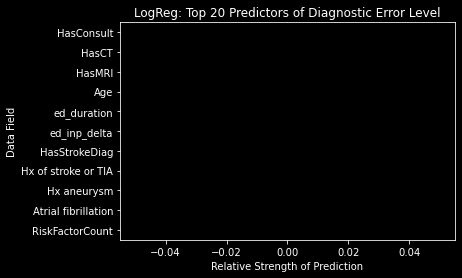

In [222]:
pseudo_labeler = cluster_umap.UMAPLabeler(reducer16, 7)
pX, py, pw = pseudo_label.pseudo_label_dataset(pseudo_labeler, X_train[X_cols], y_train[y_col], unlabeled_df[X_cols])
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-10, 10, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

best_model_log = eval_util.runLogRegWithDataset(hyperparameter_grid_log, X_cols, pX, X_test[X_cols], py, y_test[y_col], pw)

# Evaluation

In [48]:
# machine learning
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFECV, chi2, mutual_info_classif
from xgboost import XGBClassifier

In [49]:
# seed
RANDOM_STATE_SEED = 42
# train-test-split test size
TEST_SIZE = 0.15
# logistic regression model constants
LOGISTIC_REGRESSION_ITER = 10000

In [ ]:
# feature_vec = util.mergeFeatures([consult_feature, rad_feature, weekend_feature, 
#                                   age_feature, index_feature], normalize=True)
feature_vec = util.mergeFeatures([new_consult_feature, new_rad_feature, age_feature, index_feature, icd_diag_feature])
display(feature_vec)

In [235]:
label_df2 = label_df[(label_df.Label == "NoMOD") | (label_df.Label == "PMOD")]
labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(feature_vec, label_df2)

In [50]:
label_df3 = label_df[(label_df.Label == "NoMOD") | (label_df.Label == "MOD")]
labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(feature_vec, label_df3)

NameError: name 'feature_vec' is not defined

In [1]:
display(labeled_df)

NameError: name 'labeled_df' is not defined

In [290]:
import logreg
# define space of model's parameter values
hyperparameter_grid_log = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-1, 4, 10),
    'solver': ['liblinear','saga']
}

best_model_logensemble = eval_util.runGridSearch(
    logreg.UnbalancedLogisticEnsemble(10, max_iter=LOGISTIC_REGRESSION_ITER, random_state=RANDOM_STATE_SEED, class_weight='balanced'), 
    hyperparameter_grid_log, 
    labeled_df, 
    X_cols, 
    y_col)

KeyboardInterrupt: 

In [445]:
est = LogisticRegression(max_iter=LOGISTIC_REGRESSION_ITER, random_state=RANDOM_STATE_SEED, class_weight={0:(8/47), 1:(39/47)})
eval_util.runGridSearch(
    est,
    hyperparameter_grid_log, 
    labeled_df, 
    X_cols, 
    y_col)

Best penalty: l1
Best C: 1e-10
Best solver: liblinear
[[7 0]
 [6 0]]
              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70         7
         1.0       0.00      0.00      0.00         6

    accuracy                           0.54        13
   macro avg       0.27      0.50      0.35        13
weighted avg       0.29      0.54      0.38        13

[[37  0]
 [32  0]]
              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70        37
         1.0       0.00      0.00      0.00        32

    accuracy                           0.54        69
   macro avg       0.27      0.50      0.35        69
weighted avg       0.29      0.54      0.37        69



C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight={0: 0.1702127659574468,
                                                        1: 0.8297872340425532},
                                          max_iter=10000, random_state=42),
             n_jobs=1,
             param_grid={'C': array([1.00000000e-10, 3.59381366e-09, 1.29154967e-07, 4.64158883e-06,
       1.66810054e-04, 5.99484250e-03, 2.15443469e-01, 7.74263683e+00,
       2.78255940e+02, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

Best penalty: l2
Best C: 0.005994842503189409
Best solver: liblinear
[[6 1]
 [5 1]]
              precision    recall  f1-score   support

         0.0       0.55      0.86      0.67         7
         1.0       0.50      0.17      0.25         6

    accuracy                           0.54        13
   macro avg       0.52      0.51      0.46        13
weighted avg       0.52      0.54      0.47        13

[[36  1]
 [24  8]]
              precision    recall  f1-score   support

         0.0       0.60      0.97      0.74        37
         1.0       0.89      0.25      0.39        32

    accuracy                           0.64        69
   macro avg       0.74      0.61      0.57        69
weighted avg       0.73      0.64      0.58        69



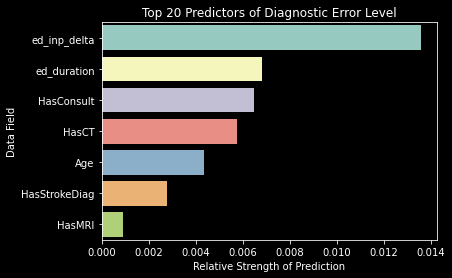

In [447]:
# define space of model's parameter values
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-10, 4, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

best_model_log = eval_util.runLogReg(hyperparameter_grid_log, labeled_df, X_cols, y_col)

Best penalty: l2
Best C: 0.21544346900318867
Best solver: liblinear
[[5 2]
 [2 4]]
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71         7
         1.0       0.67      0.67      0.67         6

    accuracy                           0.69        13
   macro avg       0.69      0.69      0.69        13
weighted avg       0.69      0.69      0.69        13

[[27 10]
 [14 18]]
              precision    recall  f1-score   support

         0.0       0.66      0.73      0.69        37
         1.0       0.64      0.56      0.60        32

    accuracy                           0.65        69
   macro avg       0.65      0.65      0.65        69
weighted avg       0.65      0.65      0.65        69

Best n_estimators: 5
Best max_depth: 5
[[3 4]
 [1 5]]
              precision    recall  f1-score   support

         0.0       0.75      0.43      0.55         7
         1.0       0.56      0.83      0.67         6

    accuracy              

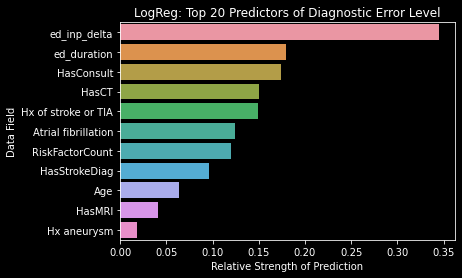

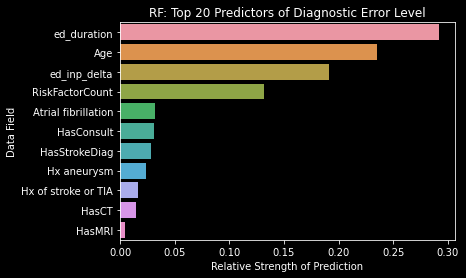

In [494]:
# define space of model's parameter values
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-10, 4, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

best_model_log = eval_util.runLogReg(hyperparameter_grid_log, labeled_df, X_cols, y_col)

# define space of model's parameter values
hyperparameter_grid_rf = {
    'n_estimators': [1, 2, 3, 5, 7]
    ,'max_depth': [2, 3, 4, 5]
}

best_model_rf = eval_util.runRandForest(hyperparameter_grid_rf, labeled_df, X_cols, y_col)

Best n_estimators: 7
Best max_depth: 2
[[6 1]
 [3 3]]
              precision    recall  f1-score   support

         0.0       0.67      0.86      0.75         7
         1.0       0.75      0.50      0.60         6

    accuracy                           0.69        13
   macro avg       0.71      0.68      0.68        13
weighted avg       0.71      0.69      0.68        13

[[29  8]
 [ 8 24]]
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78        37
         1.0       0.75      0.75      0.75        32

    accuracy                           0.77        69
   macro avg       0.77      0.77      0.77        69
weighted avg       0.77      0.77      0.77        69



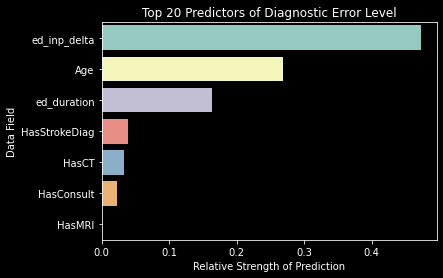

In [452]:
# define space of model's parameter values
hyperparameter_grid_rf = {
    'n_estimators': [1, 2, 3, 5, 7, 10]
    ,'max_depth': [2, 3, 4, 5]
}

best_model_rf = eval_util.runRandForest(hyperparameter_grid_rf, labeled_df, X_cols, y_col)

In [ ]:
orig_vec = util.mergeFeatures([icd_features, outpat_features, consult_feature, rad_feature, weekend_feature, 
                                  age_feature, index_feature], normalize=False)
display(orig_vec)

In [188]:
olabeled_df, ounlabeled_df, oX_cols, oy_col = util.makeDataset(orig_vec, label_df)

In [ ]:
label_df

In [220]:
temp_labeled_df = orig_vec.merge(label_df, how="inner", left_on="PatientSSN", right_on="PatientSSN")

In [ ]:
temp_labeled_df[temp_labeled_df["Label"] == "PMOD"].describe().T

In [ ]:
display(temp_labeled_df[temp_labeled_df["Label"] == "NoMOD"])

In [ ]:
display(temp_labeled_df[temp_labeled_df["Label"] == "PMOD"])

In [216]:
test_consult_feature = util.makeConsultFeature(datasubset["Consult"], edstart, 12)
test_rad_feature = util.makeRadFeature(datasubset["Rad"], edstart, 12)

In [ ]:
orig_vec = util.mergeFeatures([icd_features, outpat_features, test_consult_feature, test_rad_feature, weekend_feature, 
                                  age_feature, index_feature], normalize=False)
temp_labeled_df = orig_vec.merge(label_df, how="inner", left_on="PatientSSN", right_on="PatientSSN")
display(temp_labeled_df[temp_labeled_df["Label"] == "PMOD"])
display(temp_labeled_df[temp_labeled_df["Label"] == "MOD"])

In [ ]:
display(temp_labeled_df[temp_labeled_df["Label"] == "NoMOD"])

Best Penalty: l2
Best C: 4.641588833612779
Best Solver: liblinear
[[4 4]
 [2 5]]
              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57         8
         1.0       0.56      0.71      0.63         7

    accuracy                           0.60        15
   macro avg       0.61      0.61      0.60        15
weighted avg       0.61      0.60      0.60        15

[[26 10]
 [11 32]]
              precision    recall  f1-score   support

         0.0       0.70      0.72      0.71        36
         1.0       0.76      0.74      0.75        43

    accuracy                           0.73        79
   macro avg       0.73      0.73      0.73        79
weighted avg       0.73      0.73      0.73        79



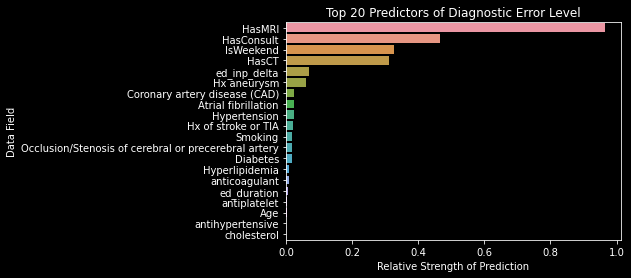

In [191]:
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-1, 4, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

obest_model_log = eval_util.runLogReg(hyperparameter_grid_log, olabeled_df, oX_cols, oy_col)

Best Number of Estimators: 10
Best Depth: 2
[[3 5]
 [4 3]]
              precision    recall  f1-score   support

         0.0       0.43      0.38      0.40         8
         1.0       0.38      0.43      0.40         7

    accuracy                           0.40        15
   macro avg       0.40      0.40      0.40        15
weighted avg       0.40      0.40      0.40        15

[[32  4]
 [ 6 37]]
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86        36
         1.0       0.90      0.86      0.88        43

    accuracy                           0.87        79
   macro avg       0.87      0.87      0.87        79
weighted avg       0.87      0.87      0.87        79



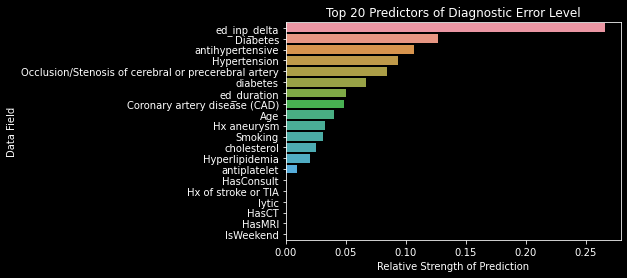

In [192]:
# define space of model's parameter values
hyperparameter_grid_rf = {
    'n_estimators': [1, 2, 3, 5, 7, 10]
    ,'max_depth': [2, 3, 4, 5]
}

best_model_rf = eval_util.runRandForest(hyperparameter_grid_rf, olabeled_df, oX_cols, oy_col)

In [ ]:
n_age_feature = util.makeAgeFeature(demo_df, False)
n_index_feature = util.makeIndexFeature(cohort_df, False)
n_feature_vec = util.mergeFeatures([icd_features, outpat_features, consult_feature, rad_feature, weekend_feature, 
                                  n_age_feature, n_index_feature], normalize=True)
display(n_feature_vec)

In [203]:
nlabeled_df, nunlabeled_df, nX_cols, ny_col = util.makeDataset(n_feature_vec, label_df)

Best Penalty: l1
Best C: 0.35938136638046275
Best Solver: liblinear
[[3 5]
 [2 5]]
              precision    recall  f1-score   support

         0.0       0.60      0.38      0.46         8
         1.0       0.50      0.71      0.59         7

    accuracy                           0.53        15
   macro avg       0.55      0.54      0.52        15
weighted avg       0.55      0.53      0.52        15

[[15 21]
 [ 6 37]]
              precision    recall  f1-score   support

         0.0       0.71      0.42      0.53        36
         1.0       0.64      0.86      0.73        43

    accuracy                           0.66        79
   macro avg       0.68      0.64      0.63        79
weighted avg       0.67      0.66      0.64        79



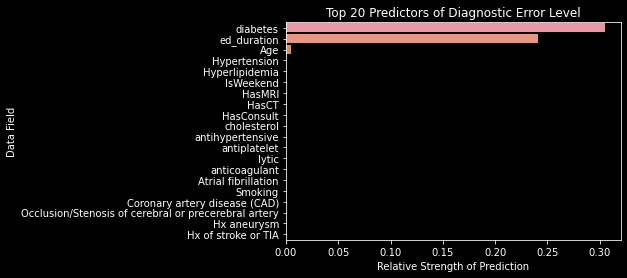

In [204]:
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-1, 4, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

nbest_model_log = eval_util.runLogReg(hyperparameter_grid_log, nlabeled_df, nX_cols, ny_col)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(labeled_df[X_cols], labeled_df[y_col], test_size=TEST_SIZE, random_state=RANDOM_STATE_SEED)

In [104]:
estimator_log = LogisticRegression(max_iter=LOGISTIC_REGRESSION_ITER, random_state=RANDOM_STATE_SEED, class_weight='balanced')

In [113]:
# define space of model's parameter values
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-1, 4, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

In [114]:
# determine best parameters to fit model ti training data
grid_search_log = GridSearchCV(
    estimator = estimator_log
    ,param_grid = hyperparameter_grid_log
    ,scoring = None
    ,n_jobs = 1
    ,cv = 5
    ,verbose = 0
    ,return_train_score = False
)

best_model_log = grid_search_log.fit(X_train, y_train)

In [115]:
# print best parameters
print('Best Penalty:', best_model_log.best_estimator_.get_params()['penalty'])
print('Best C:', best_model_log.best_estimator_.get_params()['C'])
print('Best Solver:', best_model_log.best_estimator_.get_params()['solver'])
print('Best Multi-Class:', best_model_log.best_estimator_.get_params()['multi_class'])
print('Best Fit Intercept:', best_model_log.best_estimator_.get_params()['fit_intercept'])

Best Penalty: l1
Best C: 0.1
Best Solver: saga
Best Multi-Class: auto
Best Fit Intercept: True


In [124]:
def eval_model(model, X, y):
    predictions = model.predict(X)
    print(metrics.confusion_matrix(y, predictions))
    print(metrics.classification_report(y, predictions))

In [117]:
eval_model(best_model_log, X_test, y_test)
eval_model(best_model_log, X_train, y_train)

Best Penalty: l1
Best C: 0.1
Best Solver: saga
Best Multi-Class: auto
Best Fit Intercept: True
[[8 0]
 [7 0]]
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.70         8
         1.0       0.00      0.00      0.00         7

    accuracy                           0.53        15
   macro avg       0.27      0.50      0.35        15
weighted avg       0.28      0.53      0.37        15

Best Penalty: l1
Best C: 0.1
Best Solver: saga
Best Multi-Class: auto
Best Fit Intercept: True
[[36  0]
 [43  0]]
              precision    recall  f1-score   support

         0.0       0.46      1.00      0.63        36
         1.0       0.00      0.00      0.00        43

    accuracy                           0.46        79
   macro avg       0.23      0.50      0.31        79
weighted avg       0.21      0.46      0.29        79



C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [118]:
# create a random forest model
estimator_rf = RandomForestClassifier(random_state=RANDOM_STATE_SEED, class_weight='balanced')

In [127]:
# define space of model's parameter values
hyperparameter_grid_rf = {
    'n_estimators': [1, 2, 3, 5, 7, 10]
    ,'max_depth': [1, 2, 3, 4, 5]
}

In [128]:
# determine best parameters to fit model to training data
grid_search_rf = GridSearchCV(
    estimator = estimator_rf
    ,param_grid = hyperparameter_grid_rf
    ,scoring = None
    ,n_jobs = 1
    ,cv = 5
    ,verbose = 0
    ,return_train_score = False
)

best_model_rf = grid_search_rf.fit(X_train, y_train)

In [129]:
eval_model(best_model_rf, X_test, y_test)
eval_model(best_model_rf, X_train, y_train)

[[3 5]
 [2 5]]
              precision    recall  f1-score   support

         0.0       0.60      0.38      0.46         8
         1.0       0.50      0.71      0.59         7

    accuracy                           0.53        15
   macro avg       0.55      0.54      0.52        15
weighted avg       0.55      0.53      0.52        15

[[28  8]
 [ 5 38]]
              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81        36
         1.0       0.83      0.88      0.85        43

    accuracy                           0.84        79
   macro avg       0.84      0.83      0.83        79
weighted avg       0.84      0.84      0.83        79



In [130]:
print('Best Number of Estimators:', best_model_rf.best_estimator_.get_params()['n_estimators'])
print('Best Depth:', best_model_rf.best_estimator_.get_params()['max_depth'])

Best Number of Estimators: 5
Best Depth: 3


In [132]:
rf_importances = pd.DataFrame(data=best_model_rf.best_estimator_.feature_importances_, columns=['Feature Importance'], index=X_cols)
rf_importances = rf_importances.sort_values(by=['Feature Importance'], ascending=False)

Text(0.5, 0, 'Relative Strength of Prediction')

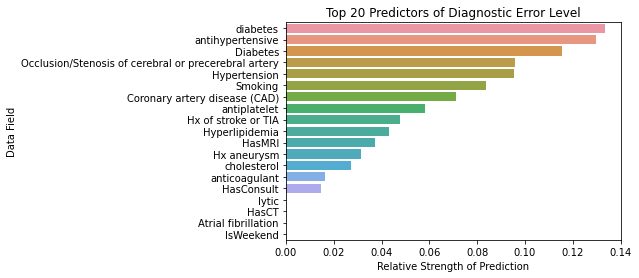

In [135]:
# create figure variables
rf_importances_20_fig, rf_importances_20_axes = plt.subplots()

temp_data = rf_importances.head(20)['Feature Importance']
sns.barplot(y=temp_data.index, x=temp_data.values, ax=rf_importances_20_axes)

# set text
rf_importances_20_axes.set_title('Top 20 Predictors of Diagnostic Error Level')
rf_importances_20_axes.set_ylabel('Data Field')
rf_importances_20_axes.set_xlabel('Relative Strength of Prediction')

In [73]:
def rescale(df, cols):
    new_df = df.copy()
    for c in cols:
        new_df[c] = MinMaxScaler().fit_transform(df[c].values.reshape(-1,1))
    return new_df

In [81]:
s_feature_vec = rescale(feature_vec, X_cols)
s_labeled_df, s_unlabeled_df, _, _ = util.makeDataset(s_feature_vec, label_df)
sX_train, sX_test, sy_train, sy_test = train_test_split(s_labeled_df[X_cols], s_labeled_df[y_col], test_size=TEST_SIZE, random_state=RANDOM_STATE_SEED)

In [ ]:
display(s_feature_vec)

In [ ]:
s_labeled_df

In [84]:
sX_train

,Hypertension,Hyperlipidemia,Diabetes,Hx of stroke or TIA,Hx aneurysm,Occlusion/Stenosis of cerebral or precerebral artery,Coronary artery disease (CAD),Smoking,Atrial fibrillation,anticoagulant,lytic,antiplatelet,antihypertensive,cholesterol,diabetes,HasConsult,HasCT,HasMRI,IsWeekend
7,0.052632,0.013333,0.002817,0.000000,0.000000,0.0,0.013158,0.00,0.0,0.0,0.0,0.000000,0.006627,0.006135,0.000000,0.0,0.0,0.0,0.0
47,0.263158,0.560000,0.000000,0.321429,0.000000,0.0,0.013158,0.22,0.0,0.0,0.0,0.000000,0.120029,0.361963,0.000000,0.0,1.0,0.0,0.0
62,0.046784,0.013333,0.129577,0.000000,0.000000,0.0,0.052632,0.00,0.0,0.0,0.0,0.102041,0.459499,0.599182,0.275758,0.0,0.0,0.0,0.0
98,0.187135,0.000000,0.121127,0.000000,0.000000,0.0,0.013158,0.00,0.0,0.0,0.0,0.000000,0.686303,0.000000,0.066667,0.0,1.0,0.0,1.0
133,0.076023,0.026667,0.000000,0.000000,0.000000,0.0,0.039474,0.00,0.0,0.0,0.0,0.000000,0.525037,0.366053,0.000000,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0.040936,0.080000,0.011268,0.000000,0.000000,0.0,0.000000,0.02,0.0,0.0,0.0,0.000000,0.330633,0.337423,0.329293,0.0,1.0,0.0,0.0
139,0.245614,0.133333,0.019718,0.014286,0.000000,0.0,0.059211,0.00,0.0,0.0,0.0,0.000000,0.164212,0.368098,0.000000,0.0,0.0,0.0,0.0
31,0.064327,0.146667,0.022535,0.000000,0.000000,0.0,0.065789,0.00,0.0,0.0,0.0,0.000000,0.322533,0.000000,0.366667,0.0,1.0,0.0,0.0
174,0.023392,0.213333,0.008451,0.000000,0.056738,0.0,0.098684,0.00,0.0,0.0,0.0,0.000000,0.411635,0.411043,0.000000,0.0,0.0,0.0,0.0


In [97]:
s_estimator_log = LogisticRegression(max_iter=LOGISTIC_REGRESSION_ITER, random_state=RANDOM_STATE_SEED, class_weight='balanced')
s_hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-5, 5, 100)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True]
}
s_grid_search_log = GridSearchCV(
    estimator = s_estimator_log
    ,param_grid = s_hyperparameter_grid_log
    ,scoring = None
    ,n_jobs = 1
    ,cv = 5
    ,verbose = 0
    ,return_train_score = False
)

s_best_model_log = s_grid_search_log.fit(sX_train, sy_train)

In [98]:
eval_model(s_best_model_log, sX_test, sy_test)
eval_model(s_best_model_log, sX_train, sy_train)

[[8 0]
 [7 0]]
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.70         8
         1.0       0.00      0.00      0.00         7

    accuracy                           0.53        15
   macro avg       0.27      0.50      0.35        15
weighted avg       0.28      0.53      0.37        15

[[36  0]
 [43  0]]
              precision    recall  f1-score   support

         0.0       0.46      1.00      0.63        36
         1.0       0.00      0.00      0.00        43

    accuracy                           0.46        79
   macro avg       0.23      0.50      0.31        79
weighted avg       0.21      0.46      0.29        79



C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
cohort_df = datasubset["cohort"]

In [139]:
cohort_df[['patientSSN', "AdmitDateTime"]].unique()

AttributeError: 'DataFrame' object has no attribute 'unique'

In [ ]:
index_vec = util.makeIndexVec(cohort_df)
display(index_vec)

In [351]:
np.max(index_vec.ed_duration / 60)

11.874166666666667

In [153]:
demo_df = datasubset["Demorgraphics"]

In [ ]:
util.makeAgeVec(demo_df)

In [163]:
temp = util.makeAgeVec(demo_df)
MinMaxScaler().fit_transform(temp.iloc[:,:])

array([[0.        , 0.73170732],
       [0.01343849, 0.85365854],
       [0.01367655, 0.53658537],
       [0.01678556, 0.92682927],
       [0.04766476, 0.70731707],
       [0.07553534, 0.3902439 ],
       [0.08179063, 0.87804878],
       [0.11115562, 0.70731707],
       [0.14214002, 0.31707317],
       [0.1437077 , 0.43902439],
       [0.16238361, 0.56097561],
       [0.16744236, 0.68292683],
       [0.17131011, 0.26829268],
       [0.18624282, 0.70731707],
       [0.19179342, 0.26829268],
       [0.19510569, 0.29268293],
       [0.22044587, 0.75609756],
       [0.23624102, 0.29268293],
       [0.24949989, 0.68292683],
       [0.27507582, 0.75609756],
       [0.29757422, 0.24390244],
       [0.30745934, 0.97560976],
       [0.30944647, 0.56097561],
       [0.3401812 , 0.6097561 ],
       [0.3468125 , 0.90243902],
       [0.35930065, 0.51219512],
       [0.3633327 , 0.26829268],
       [0.36913875, 0.48780488],
       [0.37071443, 0.68292683],
       [0.3748258 , 0.63414634],
       [0.

In [240]:
conn = pyodbc.connect("DRIVER={SQL Server};SERVER=VHACDWRB03;DATABASE=ORD_Singh_201911038D")
note_df = pd.read_sql(sql="select * from Dflt._B00_ML4TrgPos_Y201621_30_Note t", con=conn)

In [347]:
util.displayAll(note_df.TIUStandardTitle.value_counts())

ADDENDUM                                                                        263658
NURSING NOTE                                                                     91590
NURSING INPATIENT NOTE                                                           39537
ADMINISTRATIVE NOTE                                                              30790
EMERGENCY DEPT NOTE                                                              21714
TELEPHONE ENCOUNTER NOTE                                                         20207
NURSING E & M NOTE                                                               17951
LONG TERM CARE NOTE                                                              15797
PRIMARY CARE NOTE                                                                15559
NURSING FLOWSHEET                                                                14524
EMERGENCY DEPT TRIAGE NOTE                                                       10723
PHARMACY NOTE                              

In [ ]:
note_df[note_df.TIUStandardTitle.str.contains("triage", case=False)]

In [ ]:
triage_df = note_df[note_df["TIUStandardTitle"]=="EMERGENCY DEPT TRIAGE NOTE"]
display(triage_df)

In [ ]:
triage_df[triage_df.PatientSSN == "999"].iloc[0].ReportText

In [ ]:
triage_df[triage_df.PatientSSN == "999"].iloc[0].ReportText

In [ ]:
triage_df[triage_df.PatientSSN == "999"]

In [ ]:
note_df[note_df.PatientSSN == "999"]

In [ ]:
cohort_df[cohort_df.patientSSN == 99999]